# **SMAI Assignment - 1**
##### (Monsoon 2023-24)

> **Name**: *Bhav Beri*
> 
> **Roll Number**: *2021111013*

#### Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from prettytable import PrettyTable
import time

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


#### Configs

In [13]:
max_k = 15
random_state = 42

In [3]:
possible_distance_metrics = ["euclidean", "manhattan", "cosine"]
possible_weights = ["uniform", "distance"]
possible_encodings = ["resnet", "vit"]

In [4]:
run_distance_metrics = ["euclidean", "manhattan", "cosine"]
run_weights = ["uniform", ]
run_encodings = ["resnet", "vit"]

In [20]:
best_model_file_path = "best_model.pkl"

#### Utils

In [5]:
def euclidean_dist(pointA, pointB):
    sum = np.sum((pointA - pointB) ** 2)
    return np.sqrt(sum)

def manhattan_dist(pointA, pointB):
    return np.sum(np.abs(pointA - pointB))

def cosine_dist(pointA, pointB):
    return 1 - np.dot(pointA[0], pointB[0]) / (np.linalg.norm(pointA[0]) * np.linalg.norm(pointB[0]))

In [6]:
class KNN():
    def __init__(self, k: int, distance_metrics: str = "euclidean", weights: str = "uniform", encoder: str = "ResNet"):
        assert k > 0, "k must be greater than 0"
        self.k = k

        assert distance_metrics.lower() in possible_distance_metrics, "invalid distance_metrics"
        self.distance_metrics = distance_metrics.lower()
        if self.distance_metrics == "euclidean":
            self.dist_func = euclidean_dist
        elif self.distance_metrics == "manhattan":
            self.dist_func = manhattan_dist
        elif self.distance_metrics == "cosine":
            self.dist_func = cosine_dist

        assert weights.lower() in possible_weights, "invalid weights"
        self.weights = weights.lower()

        assert encoder.lower() in possible_encodings, "invalid encoder"
        self.encoder = encoder.lower()

        self.train_data = list()
        self.train_label = list()

    def fit(self, dataset):
        if self.encoder == "resnet":
            self.train_data = dataset[:,1]
        elif self.encoder == "vit":
            self.train_data = dataset[:,2]
        
        self.train_label = dataset[:,3]
    
    def predict(self, test_data):
        assert len(self.train_data) > 0, "train_data is empty"
        assert len(self.train_label) > 0, "train_label is empty"

        pred = list()
        encoder_test_data = list()
        if self.encoder == "resnet":
            encoder_test_data = test_data[:,1]
        elif self.encoder == "vit":
            encoder_test_data = test_data[:,2]
        for test in encoder_test_data:
            dist = np.array([self.dist_func(test, train) for train in self.train_data])
            idx = np.argsort(dist) # Get sorting index list

            k_labels = self.train_label[idx][:self.k]

            # Written with help from GitHub Copilot
            if self.weights == "uniform":
                unique_labels, label_counts = np.unique(k_labels, return_counts=True)
                pred.append(unique_labels[np.argmax(label_counts)])
            elif self.weights == "distance":
                k_dist = dist[idx][:self.k]
                weights = 1 / k_dist
                unique_labels, label_weights = np.unique(k_labels, return_inverse=True)
                weighted_counts = np.bincount(label_weights, weights=weights)
                pred.append(unique_labels[np.argmax(weighted_counts)])
                # label_weights = np.bincount(k_labels, weights=weights, minlength=np.max(k_labels) + 1)
                # pred.append(np.argmax(label_weights))
        return pred
    
    def scoring(self, actual_labels, pred_labels):
        f1 = f1_score(actual_labels, pred_labels, zero_division=0, average='weighted')
        accuracy = accuracy_score(actual_labels, pred_labels)
        precision = precision_score(actual_labels, pred_labels, zero_division=0, average='weighted')
        recall = recall_score(actual_labels, pred_labels, zero_division=0, average='weighted')

        # Return a dictionary of scores rounded off to 4 decimal places
        return {'f1': round(f1, 4), 'accuracy': round(accuracy, 4), 'precision': round(precision, 4), 'recall': round(recall, 4)}

#### Main Code

(1500, 5) (5,) (1, 512)
Max Frequency Label: flute with Value = 26
Min Frequency Label: dig with Value = 1


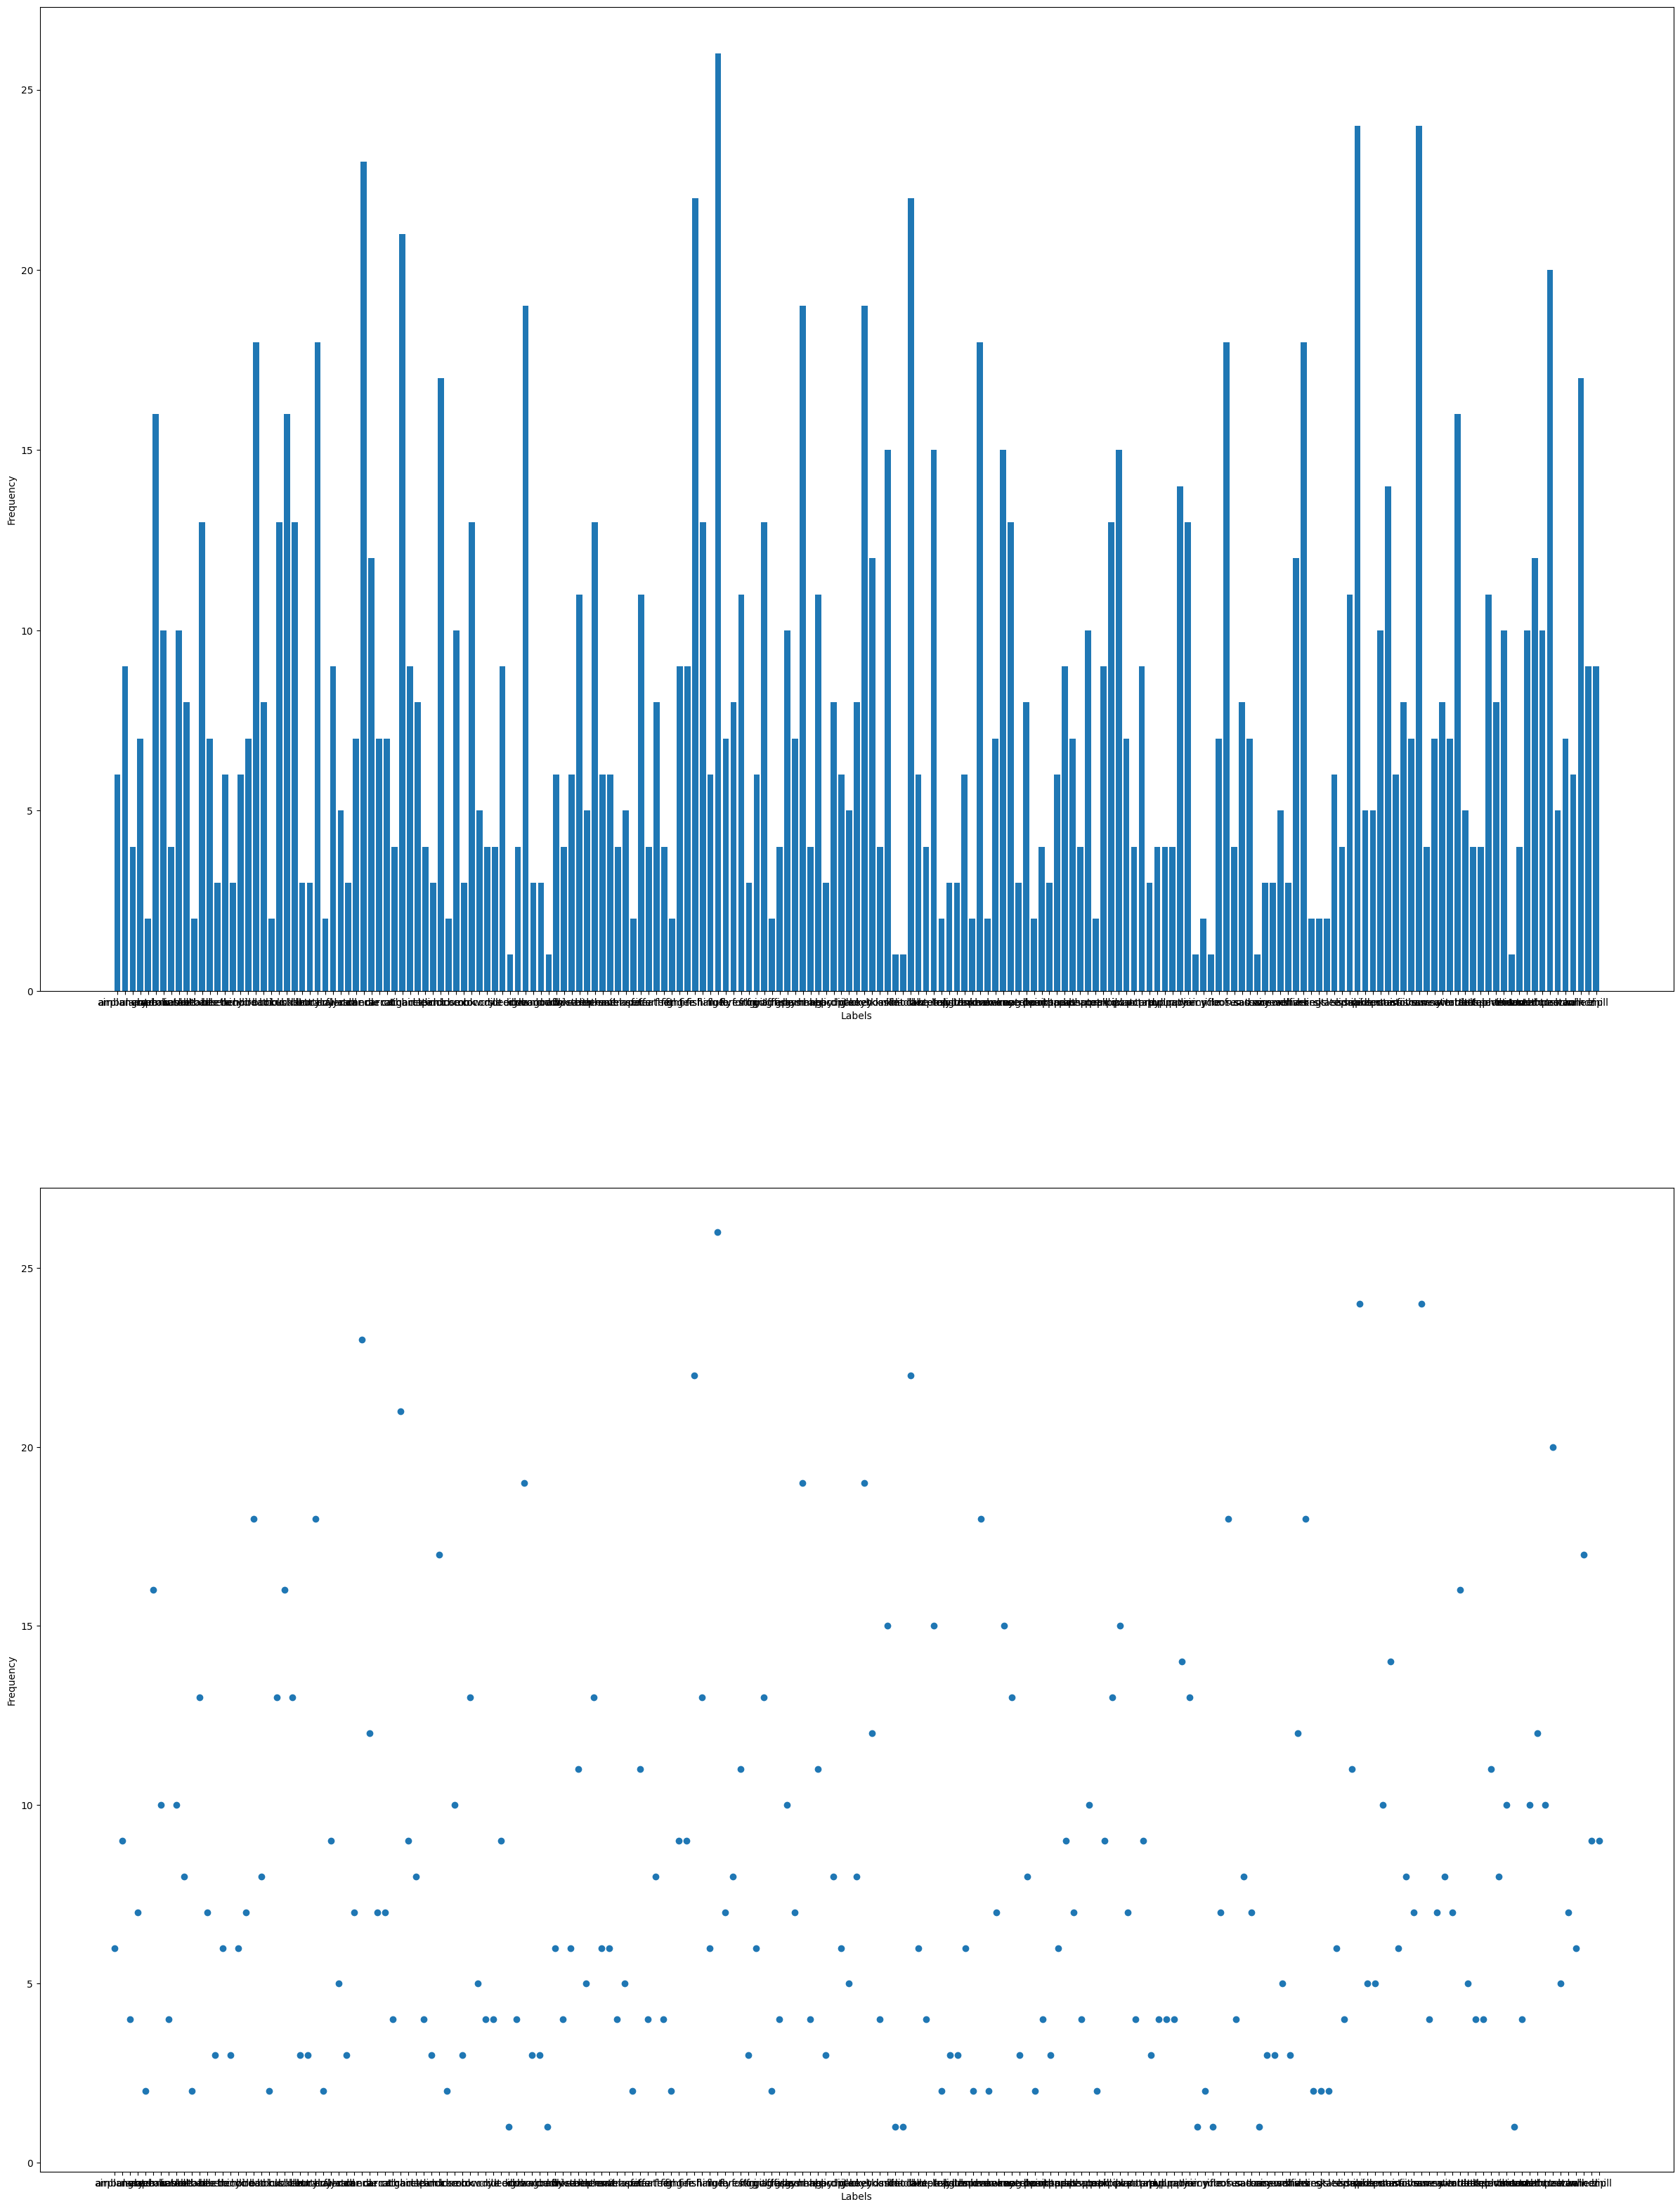

In [7]:
data = np.array(np.load('data.npy', allow_pickle=True))

print(data.shape, data[0].shape, data[0][2].shape)

labels = data[:,3]
labels_frequency = dict()

for label in np.unique(labels):
    labels_frequency[label] = np.sum(labels == label)

print("Max Frequency Label:", max(labels_frequency, key=labels_frequency.get), "with Value =", max(labels_frequency.values()))
print("Min Frequency Label:", min(labels_frequency, key=labels_frequency.get), "with Value =", min(labels_frequency.values()))       

fig, axs = plt.subplots(2,1, figsize=(30, 40))

axs[0].bar(list(labels_frequency.keys()), list(labels_frequency.values()))
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Frequency')

axs[1].scatter(list(labels_frequency.keys()), list(labels_frequency.values()))
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')
plt.show()

In [8]:
# Prepare Data

data_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random_state)

In [9]:
# Get all possible combinations of hyperparameters
all_scores = list()

for k in range(1, max_k + 1):
    for distance_metrics in run_distance_metrics:
        for weights in run_weights:
            for encoder in run_encodings:
                print("k =", k, "| distance_metrics =", distance_metrics, "| weights =", weights, "| encoder =", encoder)
                knn = KNN(k=k, distance_metrics=distance_metrics, weights=weights, encoder=encoder)
                knn.fit(data_train)
                start = time.time()
                pred = knn.predict(X_test)
                end = time.time()
                score = knn.scoring(y_test, pred)
                time_taken = end - start
                print("Time:", time_taken, "s")
                print("Score:", score)
                print("")
                score["time"] = round(time_taken, 4)
                all_scores.append([score, k, distance_metrics, weights, encoder])

k = 1 | distance_metrics = euclidean | weights = uniform | encoder = resnet
Time: 3.222677707672119 s
Score: {'f1': 0.1838, 'accuracy': 0.1867, 'precision': 0.2191, 'recall': 0.1867}

k = 1 | distance_metrics = euclidean | weights = uniform | encoder = vit
Time: 2.5155045986175537 s
Score: {'f1': 0.2552, 'accuracy': 0.27, 'precision': 0.2778, 'recall': 0.27}

k = 1 | distance_metrics = manhattan | weights = uniform | encoder = resnet
Time: 2.90761661529541 s
Score: {'f1': 0.1846, 'accuracy': 0.1867, 'precision': 0.2186, 'recall': 0.1867}

k = 1 | distance_metrics = manhattan | weights = uniform | encoder = vit
Time: 2.207826852798462 s
Score: {'f1': 0.2633, 'accuracy': 0.2767, 'precision': 0.3037, 'recall': 0.2767}

k = 1 | distance_metrics = cosine | weights = uniform | encoder = resnet
Time: 3.494187355041504 s
Score: {'f1': 0.197, 'accuracy': 0.2033, 'precision': 0.24, 'recall': 0.2033}

k = 1 | distance_metrics = cosine | weights = uniform | encoder = vit
Time: 2.9995005130767822 s

In [10]:
# Sort the combinations based on accuracy score
all_scores.sort(key=lambda x: x[0]["accuracy"], reverse=True)

In [25]:
# Best Model

best_model = KNN(k=all_scores[0][1], distance_metrics=all_scores[0][2], weights=all_scores[0][3], encoder=all_scores[0][4])
best_model.fit(data_train)

fp = open(best_model_file_path, "wb+")
pickle.dump(best_model, fp)
fp.close()

print("Best Triplet:")
print("k =", all_scores[0][1], "distance_metrics =", all_scores[0][2], "weights =", all_scores[0][3], "encoder =", all_scores[0][4])
print("Score:", all_scores[0][0])

Best Triplet:
k = 1 distance_metrics = manhattan weights = uniform encoder = vit
Score: {'f1': 0.2633, 'accuracy': 0.2767, 'precision': 0.3037, 'recall': 0.2767, 'time': 2.2078}


In [31]:
# Check the Best Model Saved

fp = open(best_model_file_path, "rb")
best_model = pickle.load(fp)
fp.close()

pred = best_model.predict(X_test)
scores = best_model.scoring(y_test, pred)
old_scores = all_scores[0][0]
del old_scores['time']

print(scores == old_scores)

True


In [22]:
# Top 20 triplets in a table format

print("Top 20 Triplets:")

x = PrettyTable()
x.field_names = ["Rank", "k", "distance_metrics", "weights", "encoder", "accuracy", "f1", "precision", "recall", "time"]
x.add_rows([[i+1, all_scores[i][1], all_scores[i][2], all_scores[i][3], all_scores[i][4], all_scores[i][0]["accuracy"], all_scores[i][0]["f1"], all_scores[i][0]["precision"], all_scores[i][0]["recall"], all_scores[i][0]["time"]] for i in range(20)])
print(x)

Top 20 Triplets:
+------+----+------------------+---------+---------+----------+--------+-----------+--------+--------+
| Rank | k  | distance_metrics | weights | encoder | accuracy |   f1   | precision | recall |  time  |
+------+----+------------------+---------+---------+----------+--------+-----------+--------+--------+
|  1   | 1  |    manhattan     | uniform |   vit   |  0.2767  | 0.2633 |   0.3037  | 0.2767 | 2.2078 |
|  2   | 1  |    euclidean     | uniform |   vit   |   0.27   | 0.2552 |   0.2778  |  0.27  | 2.5155 |
|  3   | 1  |      cosine      | uniform |   vit   |   0.26   | 0.244  |   0.2604  |  0.26  | 2.9995 |
|  4   | 12 |    manhattan     | uniform |   vit   |   0.26   | 0.2305 |   0.268   |  0.26  | 2.1736 |
|  5   | 13 |    manhattan     | uniform |   vit   |  0.2533  | 0.2193 |   0.2471  | 0.2533 | 2.0754 |
|  6   | 14 |    manhattan     | uniform |   vit   |  0.2533  | 0.2173 |   0.2387  | 0.2533 | 2.0885 |
|  7   | 11 |    manhattan     | uniform |   vit   |  0.

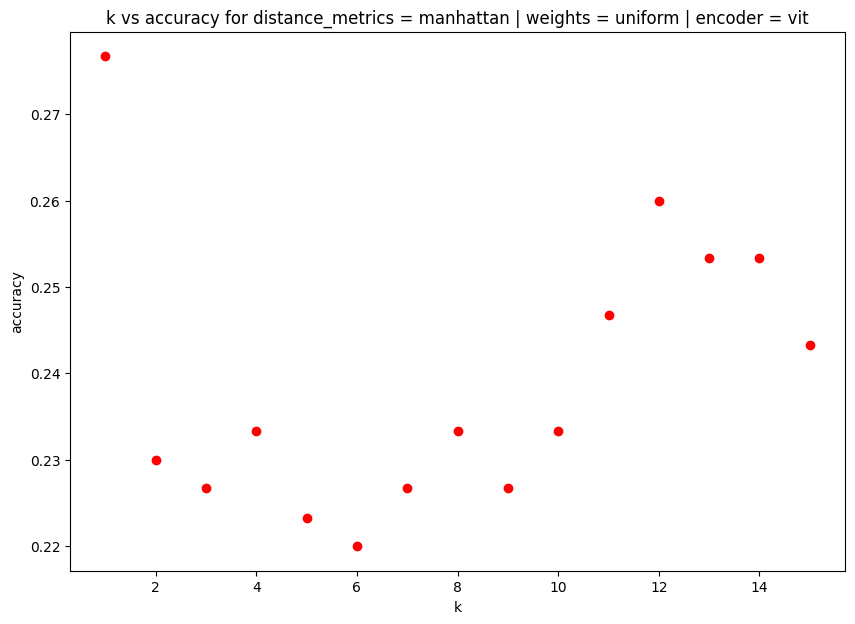

In [23]:
# Plot k vs accuracy for a fixed distance_metrics, weights and encoder

encoder = "vit"
distance_metrics = "manhattan"
weights = "uniform"
k = [all_scores[i][1] for i in range(len(all_scores)) if all_scores[i][2] == distance_metrics and all_scores[i][3] == weights and all_scores[i][4] == encoder]
accuracy = [all_scores[i][0]["accuracy"] for i in range(len(all_scores)) if all_scores[i][2] == distance_metrics and all_scores[i][3] == weights and all_scores[i][4] == encoder]

plt.figure(figsize=(10, 7))
plt.scatter(k, accuracy, color='red')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("k vs accuracy for distance_metrics = " + distance_metrics + " | weights = " + weights + " | encoder = " + encoder)
plt.show()